In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [164]:
import pydicom
import scipy.ndimage

def load_dicom(folder):
    # read all DICOM files
    files = [pydicom.dcmread(os.path.join(folder, f)) 
             for f in os.listdir(folder) if f.endswith(".dcm")]
    
    # sort by InstanceNumber (slice order)
    files.sort(key=lambda x: int(x.InstanceNumber))
    
    # extract pixel data and stack into 3D array
    volume = np.stack([f.pixel_array for f in files], axis=0)
    
    # convert to Hounsfield Units if available
    # intercept = files[0].RescaleIntercept
    # slope = files[0].RescaleSlope
    # volume = volume.astype(np.int16) * slope + intercept

    ds = files[0]
    metadata = {
        "PatientID": getattr(ds, "PatientID", None),
        "PatientName": getattr(ds, "PatientName", None),
        "PatientSex": getattr(ds, "PatientSex", None),
        "PatientBirthDate": getattr(ds, "PatientBirthDate", None),
        "StudyDate": getattr(ds, "StudyDate", None),
        "StudyDescription": getattr(ds, "StudyDescription", None),
        "SeriesDescription": getattr(ds, "SeriesDescription", None),
        "Modality": getattr(ds, "Modality", None),
        "Rows": getattr(ds, "Rows", None),
        "Columns": getattr(ds, "Columns", None),
        "PixelSpacing": getattr(ds, "PixelSpacing", None),
        "SliceThickness": getattr(ds, "SliceThickness", None),
        "NumSlices": volume.shape[0],
    }
    
    return volume, metadata

def load_dicom_meta(folder):
    # find a single file (skip listdir when possible)
    first_file = next(
        (os.path.join(folder, f) for f in os.scandir(folder) if f.is_file()), 
        None
    )
    if first_file is None:
        return None

    # read metadata only (skip pixel data)
    ds = pydicom.dcmread(first_file, stop_before_pixels=True)

    metadata = {
        "PatientID": getattr(ds, "PatientID", None),
        "PatientSex": getattr(ds, "PatientSex", None),
        "StudyDescription": getattr(ds, "StudyDescription", None),
        "SeriesDescription": getattr(ds, "SeriesDescription", None),
        "Modality": getattr(ds, "Modality", None),
        "Rows": getattr(ds, "Rows", None),
        "Columns": getattr(ds, "Columns", None),
        "PixelSpacing": getattr(ds, "PixelSpacing", None),
        "SliceThickness": getattr(ds, "SliceThickness", None),
        "NumSlices": sum(1 for _ in os.scandir(folder) if _.is_file()),
    }

    return metadata

def reshape_volume(volume, original_spacing, target_spacing=(1.0,1.0,1.0), target_shape=None):
    """
    Resample and pad/crop a 3D volume to desired spacing and shape.

    Parameters
    ----------
    volume : np.ndarray
        3D array with shape (z, y, x) or (slices, rows, cols)
    original_spacing : tuple/list of 3 floats
        Original voxel spacing: (z_spacing, y_spacing, x_spacing)
    target_spacing : tuple/list of 3 floats, optional
        Desired voxel spacing (z, y, x). Default is (1,1,1)
    target_shape : tuple/list of 3 ints, optional
        Desired output shape (z, y, x). If None, only resampling is done.

    Returns
    -------
    resampled_padded : np.ndarray
        3D volume with target spacing and shape
    """
    # Step 1: Compute zoom factors
    zoom_factors = np.array(original_spacing) / np.array(target_spacing)
    
    # Step 2: Resample volume
    resampled = scipy.ndimage.zoom(volume, zoom=zoom_factors, order=1)  # linear interpolation
    
    # Step 3: Pad or crop to target shape if provided
    if target_shape is not None:
        output = np.zeros(target_shape, dtype=resampled.dtype)
        
        # Determine cropping or padding per axis
        start_idxs = []
        end_idxs = []
        resampled_slices = []
        
        for dim in range(3):
            diff = target_shape[dim] - resampled.shape[dim]
            
            if diff >= 0:
                # Padding case → center the resampled volume
                pad_before = diff // 2
                pad_after = diff - pad_before
                start = pad_before
                end = start + resampled.shape[dim]
                resampled_slice = slice(0, resampled.shape[dim])
            else:
                # Cropping case → take centered crop from resampled
                crop = -diff
                crop_before = crop // 2
                crop_after = crop - crop_before
                start = 0
                end = target_shape[dim]
                resampled_slice = slice(crop_before, resampled.shape[dim] - crop_after)
            
            start_idxs.append(start)
            end_idxs.append(end)
            resampled_slices.append(resampled_slice)
        
        # Insert into output
        output[
            start_idxs[0]:end_idxs[0],
            start_idxs[1]:end_idxs[1],
            start_idxs[2]:end_idxs[2]
        ] = resampled[
            resampled_slices[0],
            resampled_slices[1],
            resampled_slices[2]
        ]
        
        return output
    
    return resampled

In [7]:
# import a single series
import pandas as pd
 
folder = '/kaggle/input/rsna-intracranial-aneurysm-detection/series'
fileNum = 0

filenames = os.listdir(folder)
N = len(filenames)

metadata = []

for i in range(N):
    subject = os.path.join(folder,filenames[i])
    
    # print(os.listdir(subject))
    
    # dcm,metadata = load_dicom(subject)
    
    # dcm.shape
    metadata.append(load_dicom_meta(subject))
    
    # print(metadata)

df = pd.DataFrame(metadata)
# df.to_csv('series_metadata.csv',index=False)


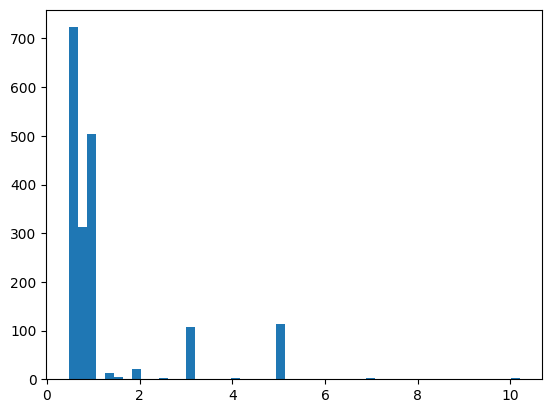

In [11]:
#%% compare modalities
import matplotlib.pyplot as plt

plt.hist(df[df['Modality'] == 'CT']['SliceThickness'],bins=50)
plt.show()

In [ ]:
# show image
import matplotlib.pyplot as plt

folder = '/kaggle/input/rsna-intracranial-aneurysm-detection/series'
filenames = os.listdir(folder)

dcm,d_meta = load_dicom(os.path.join(folder,filenames[0]))

original_spacing = (float(d_meta['SliceThickness']),d_meta['PixelSpacing'][0],d_meta['PixelSpacing'][1])      # z, y, x spacing in mm

# Desired spacing and output shape
target_spacing = (3.0, 1.0, 1.0)
target_shape = (64, 256, 256)

dcm_reshaped = reshape_volume(dcm, original_spacing, target_spacing, target_shape)


61
32


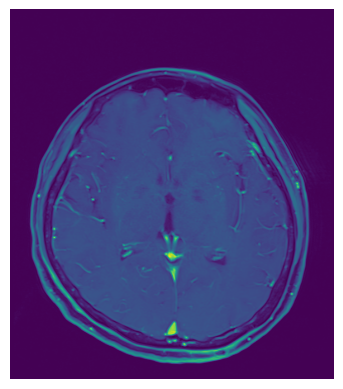

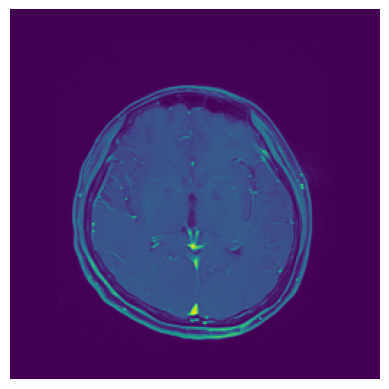

(120, 448, 392)

In [6]:
r_frame = 30
frame = int((r_frame+1)*target_spacing[0]/original_spacing[0]-1)
r_frame = r_frame+2

print(frame)
print(r_frame)

plt.imshow(dcm[frame])
plt.axis('off')
plt.show()

plt.imshow(dcm_reshaped[r_frame])
plt.axis('off')
plt.show()

dcm.shape

In [21]:
d_meta['PixelSpacing']
d_meta['SliceThickness']
d_meta

{'PatientID': 'cf7f374b-256',
 'PatientName': 'cf7f374b-256',
 'PatientSex': 'F',
 'PatientBirthDate': None,
 'StudyDate': '20250422',
 'StudyDescription': 'MRI Brain',
 'SeriesDescription': 't1fs_3D_ax whole brain_GD.',
 'Modality': 'MR',
 'Rows': 448,
 'Columns': 392,
 'PixelSpacing': [0.4910714328289, 0.4910714328289],
 'SliceThickness': '1.5',
 'NumSlices': 120}